In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

## Boilerplate needed for notebooks

In [2]:
run_dir = "../results/Debug_09-08-2022_13-35-00/"
current_checkpoint = 50
device_idx = [0]

In [3]:
import sys
import os 
import math
sys.path.append(os.path.dirname(os.getcwd()) + "/src/")

import numpy as np
import torch
import omegaconf

from eval.utils import encode_features
from model.model import Model
from experiment import ExperimentConfig
from dataloader.contrastive_dataloader import get_dataloader
from dataloader.utils import get_unaugmented_dataloader

# Set the default device
default_device = torch.device("cuda:0")
# Load config
cfg = omegaconf.OmegaConf.load(run_dir + ".hydra/config.yaml")
# Load model
model = Model.initialize_model(cfg.model_cfg, device_idx)
state_dict = torch.load(run_dir + f"checkpoints/checkpoint_epoch{current_checkpoint}.pt")
model.load_state_dict(state_dict['model_state'])
# Manually override directory for dataloaders
cfg.train_dataloader_cfg.dataset_cfg.dataset_dir = "../datasets"
cfg.train_dataloader_cfg.batch_size = 32
cfg.eval_dataloader_cfg.dataset_cfg.dataset_dir = "../datasets"
# Load dataloaders
train_dataset, train_dataloader = get_dataloader(cfg.train_dataloader_cfg)
eval_dataset, eval_dataloader = get_dataloader(cfg.eval_dataloader_cfg)
unaugmented_train_dataloader = get_unaugmented_dataloader(train_dataloader)
# Get encoding of entire dataset
train_eval_input = encode_features(model, unaugmented_train_dataloader, default_device)
# Load transport operators
psi = model.contrastive_header.transop_header.transop.get_psi()

Using cache found in /home/kion/.cache/torch/hub/pytorch_vision_v0.10.0
/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
coeff_list = []
for idx, batch in enumerate(train_dataloader):
    x_list = list(batch[0])
    # Tensor of input images of shape [B x V x H x W x C]
    x_gpu = torch.stack([x.to(default_device) for x in x_list]).transpose(0, 1)
    x_idx = torch.Tensor([int(idx) for idx in batch[2]])

    model_output = model(x_gpu, x_idx)
    coeff_list.append(model_output.distribution_data.samples.detach().cpu().numpy())
    #loss_metadata, total_loss = model.compute_loss(model_output)


/home/kion/manifold-contrastive/src/model/manifold/transop.py:18: UserWarning: An output with one or more elements was resized since it had shape [2, 512, 512], which does not match the required output shape [1, 2, 512, 512]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  out = torch.matrix_exp(T) @ x
/home/kion/manifold-contrastive/src/model/manifold/transop.py:18: UserWarning: An output with one or more elements was resized since it had shape [7, 512, 512], which does not match the required output shape [1, 7, 512, 512]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Tri

In [14]:
mini_coeff_list = np.concatenate(coeff_list)[:5000]
count_nz = np.zeros(len(psi) + 1, dtype=int)
coeff_nz = np.count_nonzero(mini_coeff_list, axis=0)
total_nz = np.count_nonzero(mini_coeff_list, axis=1)
for z in range(len(total_nz)):
    count_nz[total_nz[z]] += 1

(129,)


In [25]:
number_operator_uses = np.count_nonzero(mini_coeff_list, axis=0) / len(mini_coeff_list)

Text(0.5, 1.0, 'Transport Operator Index')

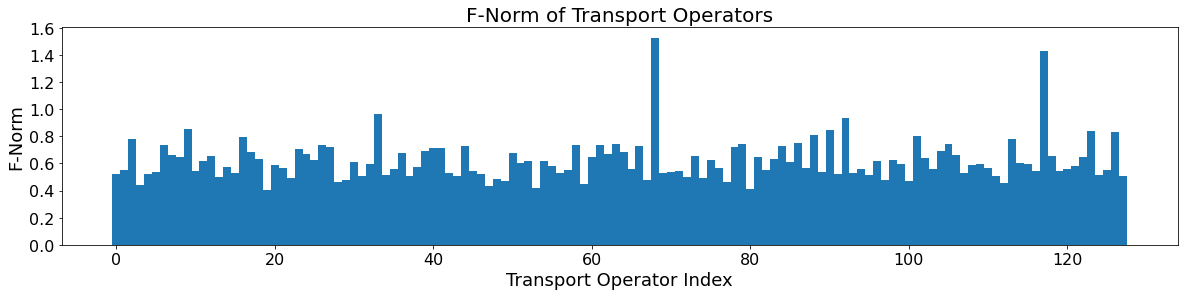

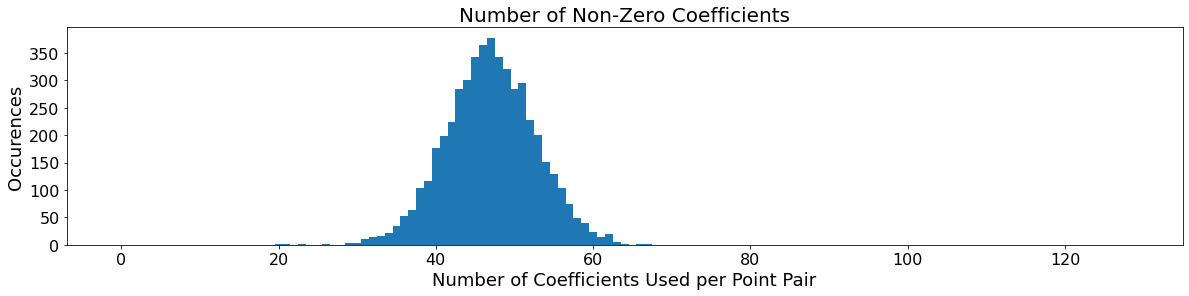

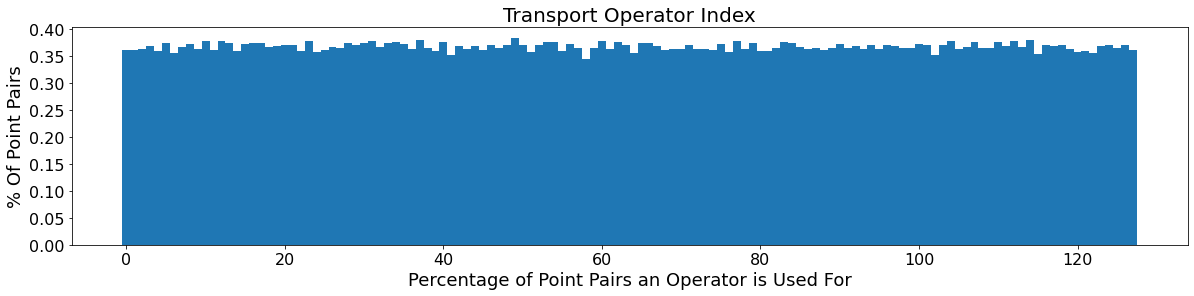

In [26]:
transop_norms = ((psi.reshape(len(psi), -1))**2).sum(dim=-1).detach().cpu().numpy()
fig = plt.figure(figsize=(20, 4))
plt.bar(np.arange(len(transop_norms)), transop_norms, width=1)
plt.xlabel("Transport Operator Index", fontsize=18)
plt.ylabel("F-Norm", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("F-Norm of Transport Operators", fontsize=20)

fig = plt.figure(figsize=(20, 4))
plt.bar(np.arange(len(transop_norms) + 1), count_nz, width=1)
plt.xlabel("Number of Coefficients Used per Point Pair", fontsize=18)
plt.ylabel("Occurences", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Number of Non-Zero Coefficients", fontsize=20)

fig = plt.figure(figsize=(20, 4))
plt.bar(np.arange(len(transop_norms)), number_operator_uses, width=1)
plt.xlabel("Percentage of Point Pairs an Operator is Used For", fontsize=18)
plt.ylabel("% Of Point Pairs", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Transport Operator Index", fontsize=20)